## **1. Importación de librerias y datos**
En este caso usaremos los datos limpios del precio nacional de cacao como base.

In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np

In [2]:
df_unificado = pd.read_excel('DatosCacao_multivariado.xlsx')
df_total = df_unificado.copy()

df_unificado = df_unificado.fillna(method='bfill')
train_size = int(len(df_unificado) * 0.8)
test_size = len(df_unificado) - train_size
df_unificado = df_unificado.iloc[:-test_size]
print(df_unificado.tail())


# Serie objetivo
y = df_unificado['COP/kg']

# Variables exógenas
X = df_unificado[['COP/kg (internacional)']]

        Fecha   COP/kg      TRM  COP/kg (internacional)  Inflacion  \
59 2025-03-10  23462.8  4116.80                34433.20       5.09   
60 2025-03-17  22958.2  4102.67                32237.84       5.09   
61 2025-03-24  23730.8  4168.82                33537.57       5.09   
62 2025-03-31  23407.5  4192.57                33168.13       5.09   
63 2025-04-07  23842.2  4274.03                33146.43       5.16   

    COP/kg (futuro)   Produccion  
59         34334.11  4485.554779  
60         32132.11  4485.554779  
61         33443.65  4485.554779  
62         33199.58  4485.554779  
63         33932.93  3731.890261  


C:\Users\peter\AppData\Local\Temp\ipykernel_19848\2603325322.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_unificado = df_unificado.fillna(method='bfill')


In [ ]:
import warnings

warnings.filterwarnings("ignore")

mejor_mse = float("inf")
mejores_parametros = None
mejor_modelo = None

p = d = q = range(0, 3)  # prueba valores de 0 a 2
P = D = Q = range(0, 2)  # valores típicos más bajos para estacionalidad
#s = [4, 12, 26, 52]  # periodicidad estacional

for s in [4, 13, 26, 52]:
    for i in p:
        for j in d:
            for k in q:
                for I in P:
                    for J in D:
                        for K in Q:
                            try:
                                modelo = SARIMAX(y,
                                                exog=X,
                                                order=(i,j,k),
                                                seasonal_order=(I,J,K,s),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                                resultado = modelo.fit(disp=False)

                                # Pronóstico
                                forecast = resultado.get_forecast(steps=test_size, exog=X[-test_size:])
                                pred_mean = forecast.predicted_mean
                                mse = mean_squared_error(df_total['COP/kg'][-test_size:], pred_mean)

                                if mse < mejor_mse:
                                    mejor_mse = mse
                                    mejores_parametros = ((i,j,k), (I,J,K,s))
                                    mejor_modelo = resultado
                            except:
                                continue

if mejores_parametros is not None:
    print(f'Mejor modelo SARIMA: orden no estacional {mejores_parametros[0]}, orden estacional {mejores_parametros[1]}, MSE: {mejor_mse}')
else:
    print("No se encontró un modelo SARIMA válido.")   


Mejor modelo SARIMA: orden no estacional (2, 0, 1), orden estacional (1, 1, 1, 12), MSE: 3468309.7966062687


## **2. Aplicación del modelo a los datos**

In [42]:
model = SARIMAX(y,
                exog=X,
                order=mejores_parametros[0],
                seasonal_order=(1, 1, 1, 10),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)
print(results.summary())

# Pronóstico a 52 semanas
forecast = results.get_forecast(steps=test_size, exog=X[-test_size:])
pred_mean = forecast.predicted_mean
pred_ci = forecast.conf_int()

                                     SARIMAX Results                                      
Dep. Variable:                             COP/kg   No. Observations:                   64
Model:             SARIMAX(2, 0, 1)x(1, 1, 1, 10)   Log Likelihood                -376.097
Date:                            Sun, 19 Oct 2025   AIC                            766.194
Time:                                    20:52:59   BIC                            778.358
Sample:                                         0   HQIC                           770.653
                                             - 64                                         
Covariance Type:                              opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
COP/kg (internacional)     0.3511      0.310      1.134      0.257      -0.256       0.958

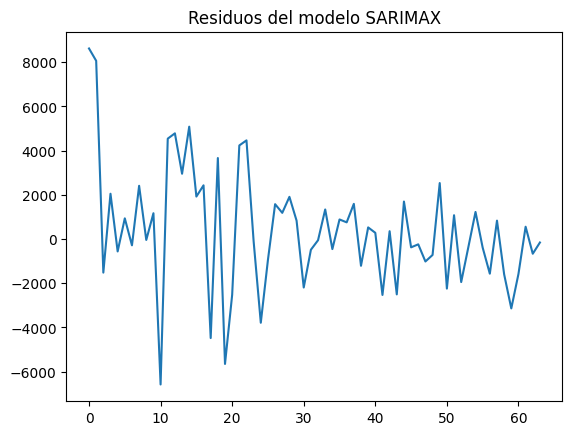

In [43]:
residuos = results.resid
import matplotlib.pyplot as plt
plt.plot(residuos)
plt.title("Residuos del modelo SARIMAX")
plt.show()

In [44]:
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(residuos, lags=[10], return_df=True)
print(lb_test)

from scipy.stats import shapiro
print(shapiro(residuos))

     lb_stat  lb_pvalue
10  3.855398   0.953635
ShapiroResult(statistic=np.float64(0.9677077746893715), pvalue=np.float64(0.09184969482280961))


1. Prueba de autocorrelación (Ljung-Box, ACF/PACF):  
Se usa para detectar dependencia temporal residual no modelada.  
Si p-valor > 0.05: no se rechaza independencia, residuos adecuados.  
Si p-valor ≤ 0.05: hay autocorrelación, revisar parámetros.  

2. Pruebas de normalidad (Shapiro-Wilk, Jarque-Bera):  
Verifica si residuos siguen distribución normal (supuesto común en modelos clásicos).  
Si p-valor > 0.05: no se rechaza normalidad, validando supuestos.  
Si p-valor ≤ 0.05: residuos no normales, considerar transformaciones sobre COP/kg o métodos robustos (modelos no lineales como LSTM o XGBoost).  

### Conclusión:
Los residuos muestran problemas importantes de autocorrelación y no normalidad, lo cual sugiere que:

* El modelo no está ajustado adecuadamente y pueden faltar términos o transformaciones para capturar la dinámica.  
* Se debería revisar o ampliar la especificación del modelo, por ejemplo, aumentar rezagos, incluir variables, cambiar componentes estacionales o probar transformaciones.  
* También puede ser conveniente probar modelos alternativos si la dinámica es compleja.

In [45]:
n_train = len(y)
steps = len(pred_mean)

# Index de las fechas donde cae el forecast (las siguientes fechas en df_total después del train)
pred_index = df_total['Fecha'].iloc[n_train:n_train+steps].reset_index(drop=True)

# Asignar ese índice al forecast
pred_mean.index = pred_index
pred_ci.index = pred_index

In [46]:
# Calcular métricas de error
mae = mean_absolute_error(df_total['COP/kg'].iloc[-test_size:], pred_mean)
rmse = np.sqrt(mean_squared_error(df_total['COP/kg'].iloc[-test_size:], pred_mean))

print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')

MAE: 1732.6423
RMSE: 2062.5974


## **3. Visualización de los resultados del forecast**

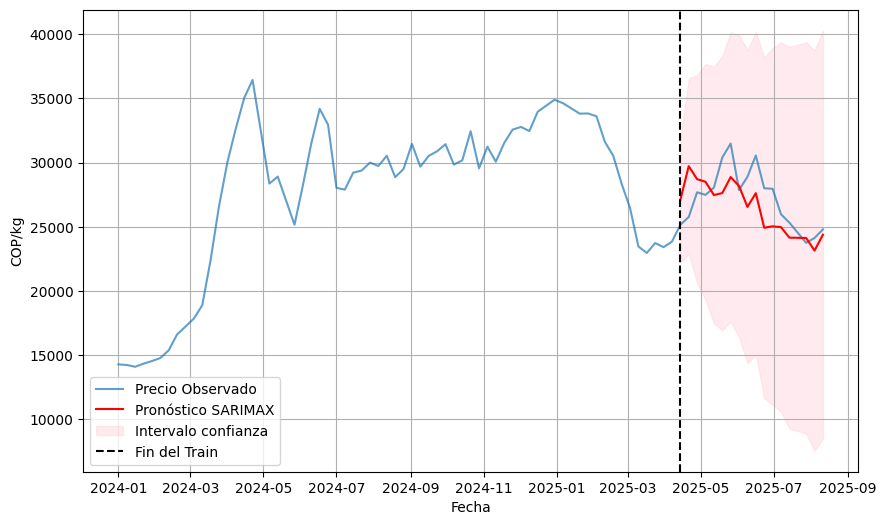

In [47]:
# Gráfico
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(df_total['Fecha'], df_total['COP/kg'], label='Precio Observado', color='C0', alpha=0.7)
plt.plot(pred_mean.index, pred_mean, label='Pronóstico SARIMAX', color='red')

plt.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='pink', alpha=0.3, label="Intervalo confianza")
plt.axvline(df_total['Fecha'].iloc[-test_size], color='k', linestyle='--', label='Fin del Train')

plt.xlabel('Fecha')
plt.ylabel('COP/kg')
plt.legend()
plt.grid(True)
plt.show()